# HSCT survival linear regression model

## Notebook set-up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import ElasticNet

## 1. Load data

In [2]:
training_features=pd.read_parquet('./data/encoded/training_features_df.parquet')
training_labels=pd.read_csv('./data/encoded/training_labels.csv')

# Remove id column from training features
training_features.drop('ID', axis=1, inplace=True)

## 2. Baseline model

In [3]:
def cross_val(model, features: pd.DataFrame, labels: pd.Series) -> list[float]:
    '''Reusable helper function to run cross-validation on a model. Takes model,
    Pandas data frame of features and Pandas data series of labels. Returns 
    list of cross-validation fold accuracy scores as percents.'''

    # Define the cross-validation strategy
    cross_validation=KFold(n_splits=7, shuffle=True, random_state=315)

    # Run the cross-validation, collecting the scores
    scores=cross_val_score(
        model,
        features,
        labels,
        cv=cross_validation,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
    )

    # Print mean and standard deviation of the scores
    print(f'Cross validation RMSE {-scores.mean():.2f} +/- {scores.std():.2f}')

    # Return the scores
    return scores

baseline_model=ElasticNet(random_state=315)
baseline_scores=cross_val(baseline_model, training_features, training_labels['efs_time'])

Cross validation RMSE 23.42 +/- 0.27


## 3. Fit and evaluate baseline model

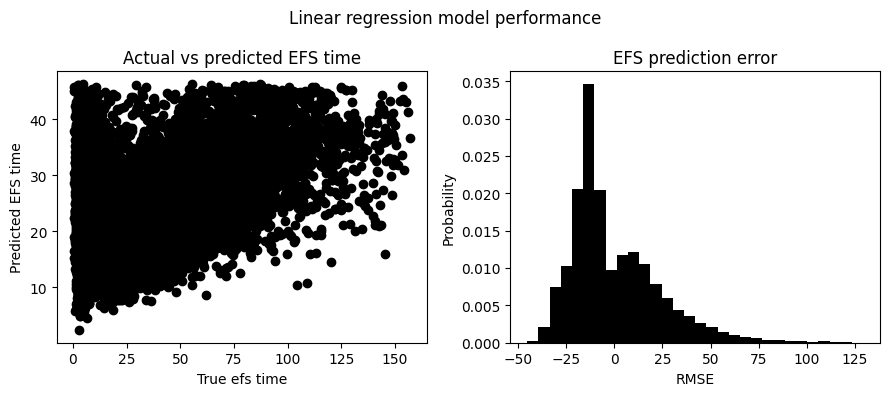

In [4]:
baseline_model.fit(training_features, training_labels['efs_time'])
predicted_efs_time=baseline_model.predict(training_features)

# Set-up a 2x1 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

fig.suptitle('Linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(training_labels['efs_time'], predicted_efs_time, color='black')
axs[0].set_xlabel('True efs time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS prediction error')
axs[1].hist(training_labels['efs_time'] - predicted_efs_time, density=True, bins=30, color='black')
axs[1].set_xlabel('RMSE')
axs[1].set_ylabel('Probability')

plt.tight_layout()
plt.show()

## 4. Hyperparameter tuning

In [5]:
# Instantiate the model
model=ElasticNet(max_iter=50000, random_state=315)

# Define the cross-validation strategy
cross_validation=KFold(n_splits=7, shuffle=True, random_state=315)

# Define the hyperparameter search space
distributions={
    'alpha': uniform(loc=0, scale=100),
    'l1_ratio': uniform(),
    'fit_intercept': [True, False],
    'positive': [True, False],
    'selection': ['cyclic', 'random']
}

# Set-up the search
search=RandomizedSearchCV(
    model,
    distributions,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=cross_validation,
    n_iter=1000,
    random_state=315,
    return_train_score=True
)

results=search.fit(training_features, training_labels['efs_time'])
print(f'Best hyperparameters: {results.best_params_}')

Best hyperparameters: {'alpha': np.float64(0.13743694392305272), 'fit_intercept': True, 'l1_ratio': np.float64(0.47247598680365765), 'positive': False, 'selection': 'cyclic'}


## 5. Fit and evaluate tuned model

Cross validation RMSE 22.91 +/- 0.28


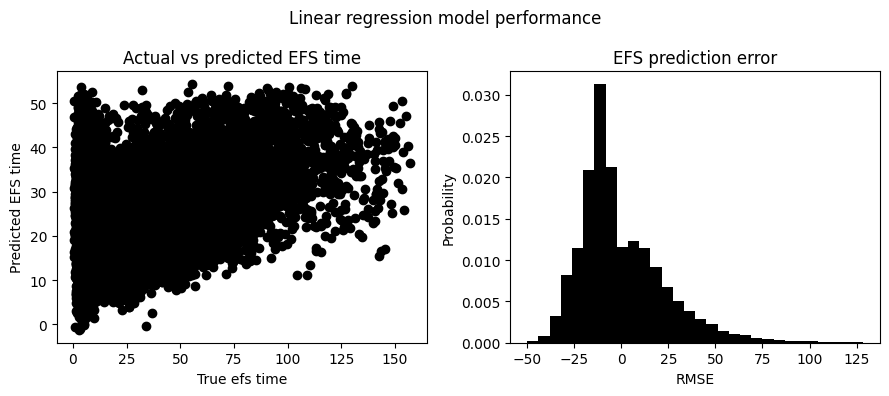

In [6]:
# Instantiate the model with the tuned hyperparameters
model=ElasticNet(**results.best_params_, max_iter=50000, random_state=315)
baseline_scores=cross_val(model, training_features, training_labels['efs_time'])

model.fit(training_features, training_labels['efs_time'])
predicted_efs_time=model.predict(training_features)

# Set-up a 2x1 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

fig.suptitle('Linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(training_labels['efs_time'], predicted_efs_time, color='black')
axs[0].set_xlabel('True efs time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS prediction error')
axs[1].hist(training_labels['efs_time'] - predicted_efs_time, density=True, bins=30, color='black')
axs[1].set_xlabel('RMSE')
axs[1].set_ylabel('Probability')

plt.tight_layout()
plt.show()

## 6. Make test set predictions

In [7]:
testing_features_df=pd.read_parquet('./data/encoded/testing_features_df.parquet')
ids=testing_features_df['ID']
testing_features_df.drop('ID', axis=1, inplace=True)
predicted_efs_time=model.predict(testing_features_df)
scaler=MinMaxScaler()
scaler.fit(predicted_efs_time.reshape(-1, 1))
predicted_efs_time=scaler.transform(predicted_efs_time.reshape(-1, 1))

predictions_df=pd.DataFrame.from_dict({'ID': ids, 'prediction': predicted_efs_time.flatten()})
predictions_df.describe()

,ID,prediction
count,3.0,3.000000
mean,28801.0,0.555307
std,1.0,0.509094
min,28800.0,0.000000
25%,28800.5,0.332960
50%,28801.0,0.665920
75%,28801.5,0.832960
max,28802.0,1.000000


In [8]:
predictions_df.to_csv('./data/submissions/linear_regression.csv', index=False)